In [ ]:
!pip install pyspark
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1rkpVBK_qkPLtwdlttw4e9UxkJ7rW4LOL' # data.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.txt')

file_id = '1yjURNlQvvzqu5jOZt5UZ0xi3UD4liQb2' # c1.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('c1.txt')

file_id = '1kWX9VDvcgwXjULFEbbMBmEfqqceuTY_P' # c2.txt
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('c2.txt')

In [ ]:
from pyspark import SparkContext, SparkConf
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = SparkContext(conf=conf)

In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# get_ipython().system_raw('./ngrok http 4050 &')
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:
MAX_ITERS = 20
NUM_CLUSTERS = 10 #k

In [ ]:
CENTROIDS_FILE_1 = 'c1.txt'
CENTROIDS_FILE_2 = 'c2.txt'
DATA_FILE = 'data.txt'

In [ ]:
EUCLIDEAN_DISTANCE = 1
MANHATTAN_DISTANCE = 2

In [ ]:
K_MEANS = 1
K_MEDIANS = 2

In [ ]:
def parse_data_file(line):

    line = line.strip().split(" ")
    points = list(map(np.float64, line))
    points = np.array(points)

    return points

In [ ]:
def get_centroids_map(centroids):
    return {idx: centroid for idx, centroid in enumerate(centroids)}

In [ ]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2) ** 2

In [ ]:
def manhattan_distance(point1, point2):
    return abs(point1 - point2).sum()

In [ ]:
def get_closest_centroid(point, centroids_map, distance_measure = EUCLIDEAN_DISTANCE):

    # Compute the distance to all the centroids, for the specified point
    points_info_list = []

    if distance_measure == EUCLIDEAN_DISTANCE:
        for centroid_num, centroid in centroids_map.items():
            points_info_list.append( ( centroid_num, #key
                                        (point, euclidean_distance(point, centroid)) # value
                                    )
                                )
    elif distance_measure == MANHATTAN_DISTANCE:
        for centroid_num, centroid in centroids_map.items():
            points_info_list.append( ( centroid_num, #key
                                        (point, manhattan_distance(point, centroid)) # value
                                    )
                                )
    else:
        raise NotImplementedError(f'{distance_measure} is not implemented.')
    
    # Sort the list to find the closest centroid to the point
    closest_centroid_info = sorted(points_info_list, key=lambda info: info[1][1], reverse=False)[0]

    return closest_centroid_info

In [ ]:
def k_means(centroids_map, data_rdd, distance_measure = EUCLIDEAN_DISTANCE):
    iteration_cost_list = []

    for iter in tqdm(range(MAX_ITERS)):
        cluster_point_rdd = data_rdd.map(lambda p: get_closest_centroid(p, centroids_map, distance_measure) )
        
        # Find the cost by summing all the distance metrics
        iteration_cost_list.append(cluster_point_rdd.map(lambda info: info[1][1]).sum())
        
        # Find the new clusteroids
        centroid_point_count_map = dict(cluster_point_rdd.countByKey())
        centroids_map = cluster_point_rdd.map(lambda info: (info[0] , info[1][0]))\
                                                .reduceByKey(lambda p1, p2: p1 + p2)\
                                                .map( lambda p: (p[0], p[1] / centroid_point_count_map[p[0]]) )\
                                                .collectAsMap()
        
    return iteration_cost_list

In [ ]:
def find_median(np_array_iterables):
    stacked_values = np.stack(list(np_array_iterables))
    return np.median(stacked_values, axis=0)

In [ ]:
def k_medians(centroids_map, data_rdd, distance_measure = MANHATTAN_DISTANCE):
    iteration_cost_list = []

    for iter in tqdm(range(MAX_ITERS)):
        cluster_point_rdd = data_rdd.map(lambda p: get_closest_centroid(p, centroids_map, distance_measure) )
        
        # Find the cost by summing all the distance metrics
        iteration_cost_list.append(cluster_point_rdd.map(lambda info: info[1][1]).sum())
        
        # Find the new clusteroids
        centroid_point_count_map = dict(cluster_point_rdd.countByKey())
        centroids_map = cluster_point_rdd.map(lambda info: (info[0] , info[1][0]))\
                                                .groupByKey()\
                                                .mapValues(find_median)\
                                                .collectAsMap()
        
    return iteration_cost_list

In [ ]:
def plot_iteration_costs(iteation_costs_c1, iteation_costs_c2, title = 'Iteration Costs'):
    plt.figure(figsize=(10, 7))
    plt.xticks([i+1 for i in range(MAX_ITERS)])
    x = [i+1 for i in range(MAX_ITERS)]
    plt.xlabel("Iterations")
    plt.ylabel("Iteration Cost")
    plt.title(title)
    plt.plot(x, iteation_costs_c1, label='C1')
    plt.plot(x, iteation_costs_c2, label='C2')

    plt.grid()

    plt.legend()

    plt.savefig(f'{title}.png')

In [ ]:
def compute_costs(data_file_path, c1_file_path, c2_file_path, centroid_method = K_MEANS, distance_measure = EUCLIDEAN_DISTANCE, title_prefix = 'Euclidean'):

    data_rdd = sc.textFile(data_file_path)
    parsed_data_rdd = data_rdd.map(parse_data_file)

    centroids_map_c1 = get_centroids_map(np.loadtxt(c1_file_path))
    centroids_map_c2 = get_centroids_map(np.loadtxt(c2_file_path))

    if centroid_method == K_MEANS:
        iteation_costs_c1 = k_means(centroids_map_c1, parsed_data_rdd, distance_measure=distance_measure)
        iteation_costs_c2 = k_means(centroids_map_c2, parsed_data_rdd, distance_measure=distance_measure)
    
    elif centroid_method == K_MEDIANS:
        iteation_costs_c1 = k_medians(centroids_map_c1, parsed_data_rdd, distance_measure=distance_measure)
        iteation_costs_c2 = k_medians(centroids_map_c2, parsed_data_rdd, distance_measure=distance_measure)
    
    else:
        raise NotImplementedError(f'{centroid_method} is not implemented.')

    plot_iteration_costs(iteation_costs_c1, iteation_costs_c2, title=f'{title_prefix} Iteration Costs')

    return iteation_costs_c1, iteation_costs_c2

In [ ]:
def calculate_percentage_difference_cost(iteration_cost, iteration_number):
    N = len(iteration_cost)
    return ((iteration_cost[iteration_number] - iteration_cost[0]) / iteration_cost[0]) * 100

100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


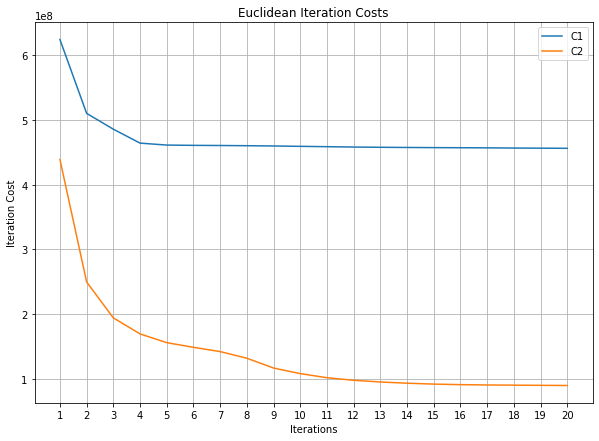

In [ ]:
eucl_c1, eucl_c2 = compute_costs(DATA_FILE, CENTROIDS_FILE_1, CENTROIDS_FILE_2, centroid_method=K_MEANS, distance_measure=EUCLIDEAN_DISTANCE, title_prefix = 'Euclidean')

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


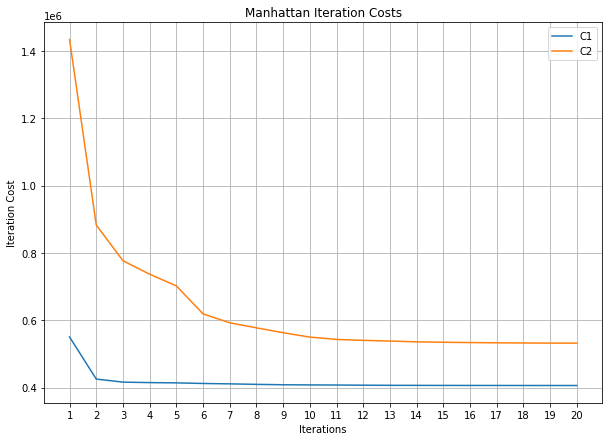

In [ ]:
man_c1, man_c2 = compute_costs(DATA_FILE, CENTROIDS_FILE_1, CENTROIDS_FILE_2, centroid_method=K_MEDIANS, distance_measure=MANHATTAN_DISTANCE, title_prefix = 'Manhattan')

In [ ]:
iteration_number = 10
print(f"The iteration cost changed by: {calculate_percentage_difference_cost(eucl_c1, iteration_number):.2f}% after {iteration_number} iteration(s) for {CENTROIDS_FILE_1} using Euclidean distance.")
print(f"The iteration cost changed by: {calculate_percentage_difference_cost(eucl_c2, iteration_number):.2f}% after {iteration_number} iteration(s) for {CENTROIDS_FILE_2} using Euclidean distance.")

The iteration cost changed by: -26.48% after 10 iteration(s) for c1.txt using Euclidean distance.
The iteration cost changed by: -76.70% after 10 iteration(s) for c2.txt using Euclidean distance.


In [ ]:
iteration_number = 10
print(f"The iteration cost changed by: {calculate_percentage_difference_cost(man_c1, iteration_number):.2f}% after {iteration_number} iteration(s) for {CENTROIDS_FILE_1} using Manhattan distance.")
print(f"The iteration cost changed by: {calculate_percentage_difference_cost(man_c2, iteration_number):.2f}% after {iteration_number} iteration(s) for {CENTROIDS_FILE_2} using Manhattan distance.")

The iteration cost changed by: -25.95% after 10 iteration(s) for c1.txt using Manhattan distance.
The iteration cost changed by: -62.14% after 10 iteration(s) for c2.txt using Manhattan distance.


In [ ]:
sc.stop()